In [1]:
# ------------------ Clustering & ML ------------------
from sklearn.cluster import SpectralBiclustering
from scipy import stats

# ------------------ Core Libraries -------------------
import numpy as np
import pandas as pd
import math
import os
import warnings
import ast
from glob import glob

# ------------------ AnnData & Spatial Analysis -------
import scanpy as sc
import squidpy as sq
from anndata import AnnData
import geopandas as gpd

# ------------------ Geometry & Spatial --------------
from shapely.ops import unary_union
from shapely.geometry import Polygon as sPolygon
from matplotlib.patches import Polygon, Patch

# ------------------ Plotting -------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, ListedColormap, to_hex
import matplotlib.image as mpimg
import matplotlib as mpl

# ------------------ Image Handling -------------------
from PIL import Image
import cv2

# ------------------ Settings -------------------------
warnings.filterwarnings('ignore')
Image.MAX_IMAGE_PIXELS = None
%matplotlib inline

/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/Users/gynecoloji/opt/anaconda3/envs/opencv/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Summary: Community Analysis - 1 (FB and EOC islands)
### Based on structural characteristics
### Based on target cell subpopulations

This section outlines the core steps:

1. **Load Data**
   - load data from QC & Filtering

2. **Selection of Slide(s)**
   - Select slides based on target cell subpopulations and their structural characteristics
   - Analyze them respectively

3. **Visualization of Structures**

4. **Cutoff for Size of Islands (optional)**
   - Set a cutoff value for determining Islands based on Area and Merged polygons

5. **Biclustering for both Islands and Cell Subpopulation**
   - Use Biclustering algorithm to cluster both Islands and cells

6. **Visualization of Clustering**

7. **Grouping Cell Subpopulations based on Distance to Islands**
   - Set up cutoffs for distances to label them different groups
  
8. **Visualization of Clustering**



In [5]:
# load data
data_read = '../raw/' # for raw data 
data_save = '../data/' # for processed data or intermediate result
analysis_save = '../analysis/' # for plots

adata = sc.read(data_save+'filtered_adata.h5ad')
cell_meta = pd.read_csv(data_save+'filtered_metadata_file.csv', index_col=0)
polygon_file = pd.read_csv(data_save+'filtered_polygons.csv', index_col=0)
coordinates = pd.read_csv(data_save+'filtered_coordinates.csv', index_col=0)
fov_id = [i for i in range(1,23) if i not in [3, 20]]

image = cv2.imread(data_read+"CellComposite/"+"CellComposite_F001.jpg", cv2.IMREAD_COLOR)
xlim_image = image.shape[1]
ylim_image = image.shape[0]

[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22]

In [7]:
# community analysis
## FOV16 was chosen for studying interactions between FB and EOC islands
## Because it has relatively balanced ratio of # of EOC to FB and EOC islands are also observed

## No cutoff limit on the size of EOC Islands
fov_chosen = 16
adata_sub = adata[adata.obs['fov'] == fov_chosen]
counts_sub = pd.DataFrame(adata_sub.X.toarray(), columns=adata_sub.var_names, index=adata_sub.obs_names)
counts_sub['cell'] = counts_sub.index.tolist()

polygon_sub_file = polygon_file[polygon_file['fov'] == fov_chosen]
polygon_set = []
cell_id = []
for cell, group in polygon_sub_file.groupby('cell'):
    polygon_tmp = sPolygon([ (i[0],i[1]) for i in group[['x_local_px', 'y_local_px']].values])
    polygon_set.append(polygon_tmp)
    cell_id.append(cell)
gdf = gpd.GeoDataFrame(geometry=polygon_set)
gdf['cell'] = cell_id
gdf = gdf.merge(adata_sub.obs[['cell','big_cell_type']],on='cell')
gdf



,geometry,cell,big_cell_type
0,"POLYGON ((3400 3644, 3405 3643, 3413 3641, 341...",16_10,IM
1,"POLYGON ((1272 3202, 1277 3201, 1280 3200, 129...",16_1000,IM
2,"POLYGON ((1528 3202, 1533 3196, 1538 3189, 153...",16_1001,IM
3,"POLYGON ((3876 3189, 3880 3185, 3880 3184, 384...",16_1002,IM
4,"POLYGON ((888 3196, 889 3195, 893 3187, 895 31...",16_1004,FB
...,...,...,...
1695,"POLYGON ((910 3209, 964 3190, 966 3186, 967 31...",16_994,IM
1696,"POLYGON ((2890 3212, 2895 3211, 2898 3210, 291...",16_996,IM
1697,"POLYGON ((4427 3202, 4453 3194, 4465 3190, 448...",16_997,IM
1698,"POLYGON ((1472 3208, 1477 3207, 1480 3206, 148...",16_998,FB


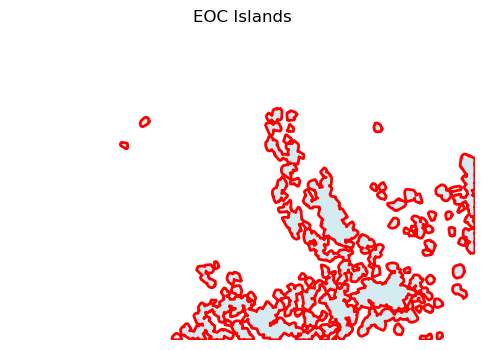

In [16]:
### EOC Islands
merged_polygon = unary_union(gdf[gdf['big_cell_type'] == 'EOC']['geometry'].tolist())

fig, ax = plt.subplots(figsize=(6,6))

if merged_polygon.geom_type == 'Polygon':
    ax.fill(*merged.exterior.xy, color='lightblue', alpha=0.5)
    ax.plot(*boundary.xy, color='red', linewidth=2)
elif merged_polygon.geom_type == 'MultiPolygon':
    for poly in merged_polygon.geoms:
        ax.fill(*poly.exterior.xy, color='lightblue', alpha=0.5)
        ax.plot(*poly.exterior.xy, color='red', linewidth=2)

ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
plt.title("EOC Islands")
plt.show()

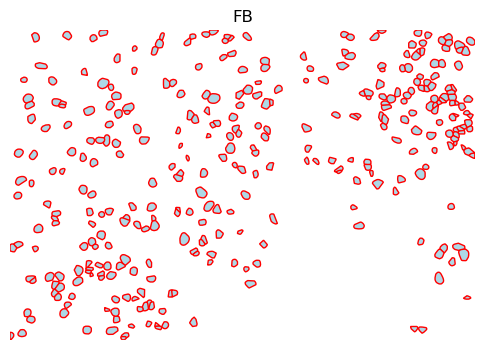

In [17]:
### FB
gdf_FB = gdf[gdf['big_cell_type'] == 'FB']

fig, ax = plt.subplots(figsize=(6,6))
gdf_FB.plot(ax=ax, color='lightblue', edgecolor='red')
ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
plt.title("FB")
plt.show()


<Figure size 400x400 with 0 Axes>

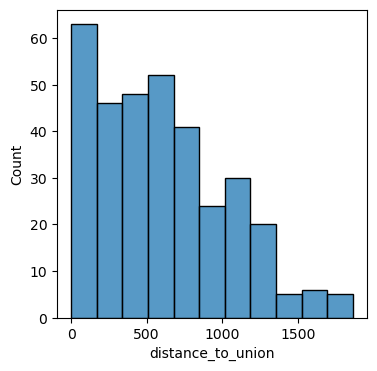

The # of FB cells touching the EOC cells is : 10


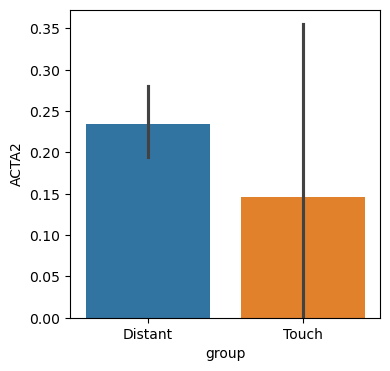

In [21]:
### play with distance between EOC Islands and FBs
gdf_FB['distance_to_union'] = gdf_FB.geometry.apply(lambda g: g.distance(merged_polygon))

plt.figure(figsize=(4,4))
sns.histplot(gdf_FB, x='distance_to_union')
plt.show()
print('The # of FB cells touching the EOC cells is : '+str(int((gdf_FB['distance_to_union'] == 0).sum())))


gdf_FB = gdf_FB.merge(counts_sub, on='cell')
gdf_FB['group'] = np.where(gdf_FB['distance_to_union'] == 0, 'Touch', 'Distant')

plt.figure(figsize=(4,4))
sns.barplot(data=gdf_FB, hue='group', x='group', y='ACTA2')
plt.show()

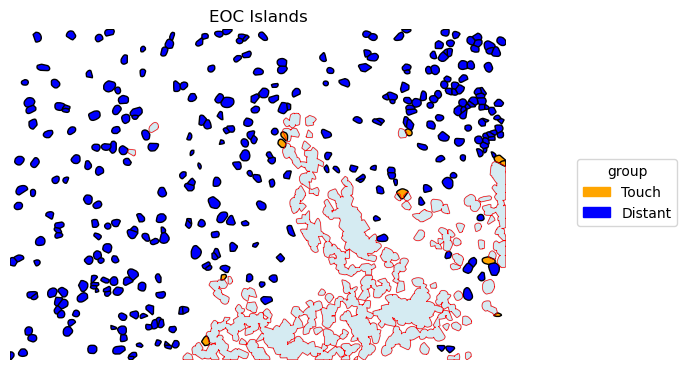

In [22]:
color_map = {'Touch':'orange', 'Distant': 'blue'}
gdf_FB['group_color'] = gdf_FB['group'].map(color_map)

fig, ax = plt.subplots()

if merged_polygon.geom_type == 'Polygon':
    ax.fill(*merged.exterior.xy, color='lightblue', alpha=0.5)
    ax.plot(*boundary.xy, color='red', linewidth=2)
elif merged_polygon.geom_type == 'MultiPolygon':
    for poly in merged_polygon.geoms:
        ax.fill(*poly.exterior.xy, color='lightblue', alpha=0.5)
        ax.plot(*poly.exterior.xy, color='red', linewidth=0.5)


gdf_FB.plot(ax=ax, color=gdf_FB['group_color'], edgecolor='black')

ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')

handles = [Patch(color=col, label=cat) for cat, col in color_map.items()]
fig.legend(handles=handles, title='group', bbox_to_anchor=(1, 0.5), loc='center left')

plt.title("EOC Islands")
plt.show()

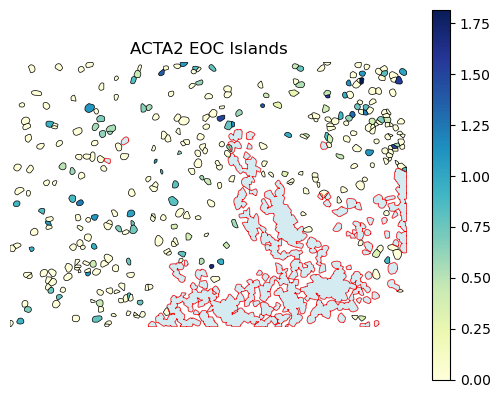

In [23]:
fig, ax = plt.subplots()

if merged_polygon.geom_type == 'Polygon':
    ax.fill(*merged.exterior.xy, color='lightblue', alpha=0.5)
    ax.plot(*boundary.xy, color='red', linewidth=2)
elif merged_polygon.geom_type == 'MultiPolygon':
    for poly in merged_polygon.geoms:
        ax.fill(*poly.exterior.xy, color='lightblue', alpha=0.5)
        ax.plot(*poly.exterior.xy, color='red', linewidth=0.5)


gdf_FB.plot(column='ACTA2', cmap='YlGnBu', linewidth=0.5, edgecolor='black', ax=ax, legend=True)

ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')

plt.title("ACTA2"+" "+"EOC Islands")
plt.show()

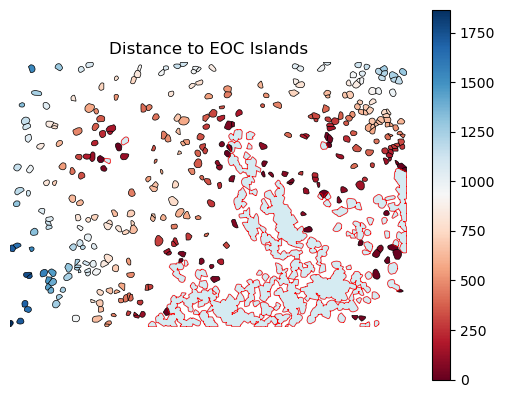

In [24]:
fig, ax = plt.subplots()

if merged_polygon.geom_type == 'Polygon':
    ax.fill(*merged.exterior.xy, color='lightblue', alpha=0.5)
    ax.plot(*boundary.xy, color='red', linewidth=2)
elif merged_polygon.geom_type == 'MultiPolygon':
    for poly in merged_polygon.geoms:
        ax.fill(*poly.exterior.xy, color='lightblue', alpha=0.5)
        ax.plot(*poly.exterior.xy, color='red', linewidth=0.5)


gdf_FB.plot(column='distance_to_union', cmap='RdBu', linewidth=0.5, edgecolor='black', ax=ax, legend=True)

ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')

plt.title("Distance to"+" "+"EOC Islands")
plt.show()

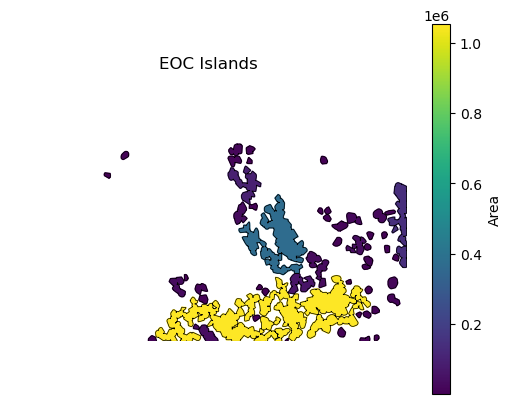

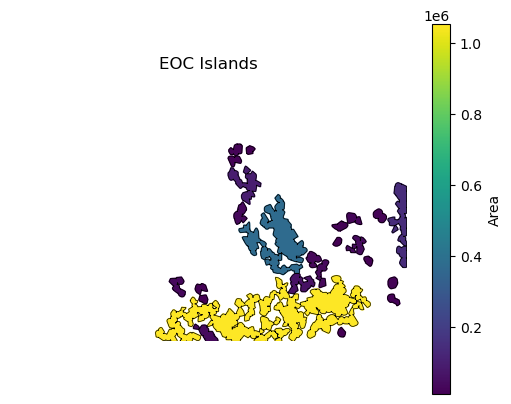

In [26]:
## set cutoff limit for EOC Islands
### EOC islands
merged_polygon = unary_union(gdf[gdf['big_cell_type'] == 'EOC']['geometry'].tolist())
merged_polygon = gpd.GeoDataFrame(geometry=list(merged_polygon.geoms))
merged_polygon["area"] = merged_polygon.geometry.area

fig, ax = plt.subplots()

norm = colors.Normalize(vmin=merged_polygon["area"].min(), vmax=merged_polygon["area"].max())
cmap = plt.cm.viridis

for _, row in merged_polygon.iterrows():
    polygon = row['geometry']
    area = row['area']
    color = cmap(norm(area))

    x, y = polygon.exterior.xy
    ax.fill(x, y, color=color)
    ax.plot(x, y, color='black', linewidth=0.5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy array for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Area')

ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
plt.title("EOC Islands")
plt.show()




merged_polygon = merged_polygon[merged_polygon["area"] > 8000]

fig, ax = plt.subplots()

norm = colors.Normalize(vmin=merged_polygon["area"].min(), vmax=merged_polygon["area"].max())
cmap = plt.cm.viridis

for _, row in merged_polygon.iterrows():
    polygon = row['geometry']
    area = row['area']
    color = cmap(norm(area))

    x, y = polygon.exterior.xy
    ax.fill(x, y, color=color)
    ax.plot(x, y, color='black', linewidth=0.5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy array for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Area')

ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
plt.title("EOC Islands")
plt.show()

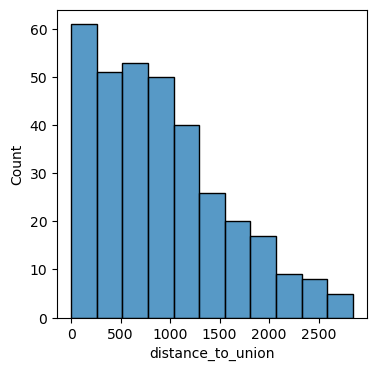

The # of FB cells touching the EOC cells is : 7


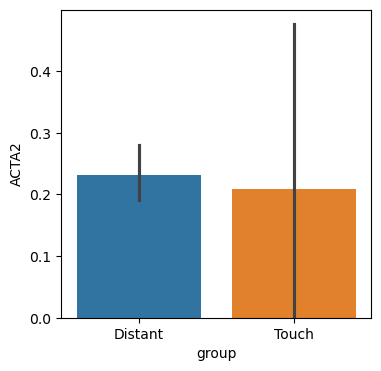

In [27]:
### FB
gdf_FB = gdf[gdf['big_cell_type'] == 'FB']
gdf_FB['distance_to_union'] = gdf_FB.geometry.apply(lambda g: g.distance(unary_union(merged_polygon['geometry'].tolist())))

plt.figure(figsize=(4,4))
sns.histplot(gdf_FB, x='distance_to_union')
plt.show()
print('The # of FB cells touching the EOC cells is : '+str(int((gdf_FB['distance_to_union'] == 0).sum())))


gdf_FB = gdf_FB.merge(counts_sub, on='cell')
gdf_FB['group'] = np.where(gdf_FB['distance_to_union'] == 0, 'Touch', 'Distant')

plt.figure(figsize=(4,4))
sns.barplot(data=gdf_FB, hue='group', x='group', y='ACTA2')
plt.show()


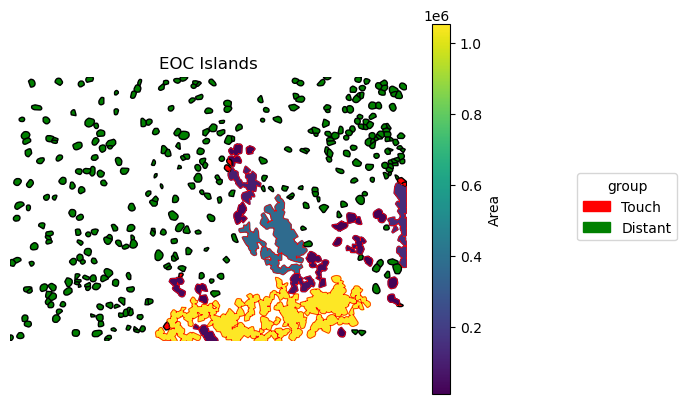

In [30]:
color_map = {'Touch':'red', 'Distant': 'green'}
gdf_FB['group_color'] = gdf_FB['group'].map(color_map)

fig, ax = plt.subplots()
# Normalize area for color mapping
norm = colors.Normalize(vmin=merged_polygon["area"].min(), vmax=merged_polygon["area"].max())
cmap = plt.cm.viridis

for _, row in merged_polygon.iterrows():
    polygon = row['geometry']
    area = row['area']
    color = cmap(norm(area))

    x, y = polygon.exterior.xy
    ax.fill(x, y, color=color)
    ax.plot(x, y, color='red', linewidth=0.5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy array for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Area')

gdf_FB.plot(ax=ax, color=gdf_FB['group_color'], edgecolor='black')

ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')

handles = [Patch(color=col, label=cat) for cat, col in color_map.items()]
fig.legend(handles=handles, title='group', bbox_to_anchor=(1, 0.5), loc='center left')

plt.title("EOC Islands")
plt.show()

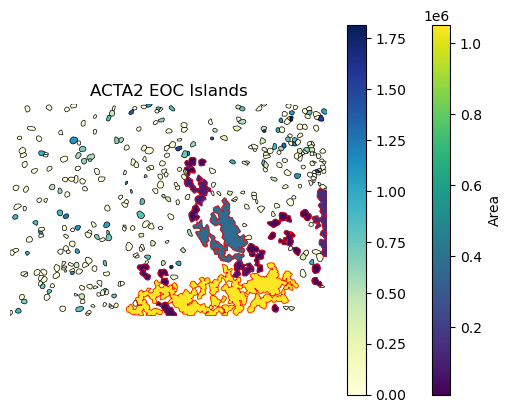

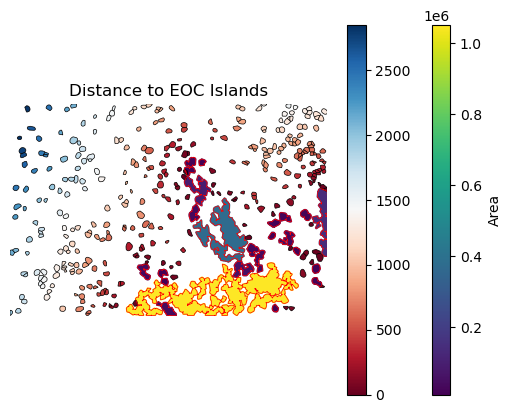

In [31]:
fig, ax = plt.subplots()

# Normalize area for color mapping
norm = colors.Normalize(vmin=merged_polygon["area"].min(), vmax=merged_polygon["area"].max())
cmap = plt.cm.viridis

for _, row in merged_polygon.iterrows():
    polygon = row['geometry']
    area = row['area']
    color = cmap(norm(area))

    x, y = polygon.exterior.xy
    ax.fill(x, y, color=color)
    ax.plot(x, y, color='red', linewidth=0.5)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy array for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Area')


gdf_FB.plot(column='ACTA2', cmap='YlGnBu', linewidth=0.5, edgecolor='black', ax=ax, legend=True)

ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')

plt.title("ACTA2"+" "+"EOC Islands")
plt.show()

fig, ax = plt.subplots()

# Normalize area for color mapping
norm = colors.Normalize(vmin=merged_polygon["area"].min(), vmax=merged_polygon["area"].max())
cmap = plt.cm.viridis

for _, row in merged_polygon.iterrows():
    polygon = row['geometry']
    area = row['area']
    color = cmap(norm(area))

    x, y = polygon.exterior.xy
    ax.fill(x, y, color=color)
    ax.plot(x, y, color='red', linewidth=0.5)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy array for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Area')


gdf_FB.plot(column='distance_to_union', cmap='RdBu', linewidth=0.5, edgecolor='black', ax=ax, legend=True)

ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')

plt.title("Distance to"+" "+"EOC Islands")
plt.show()

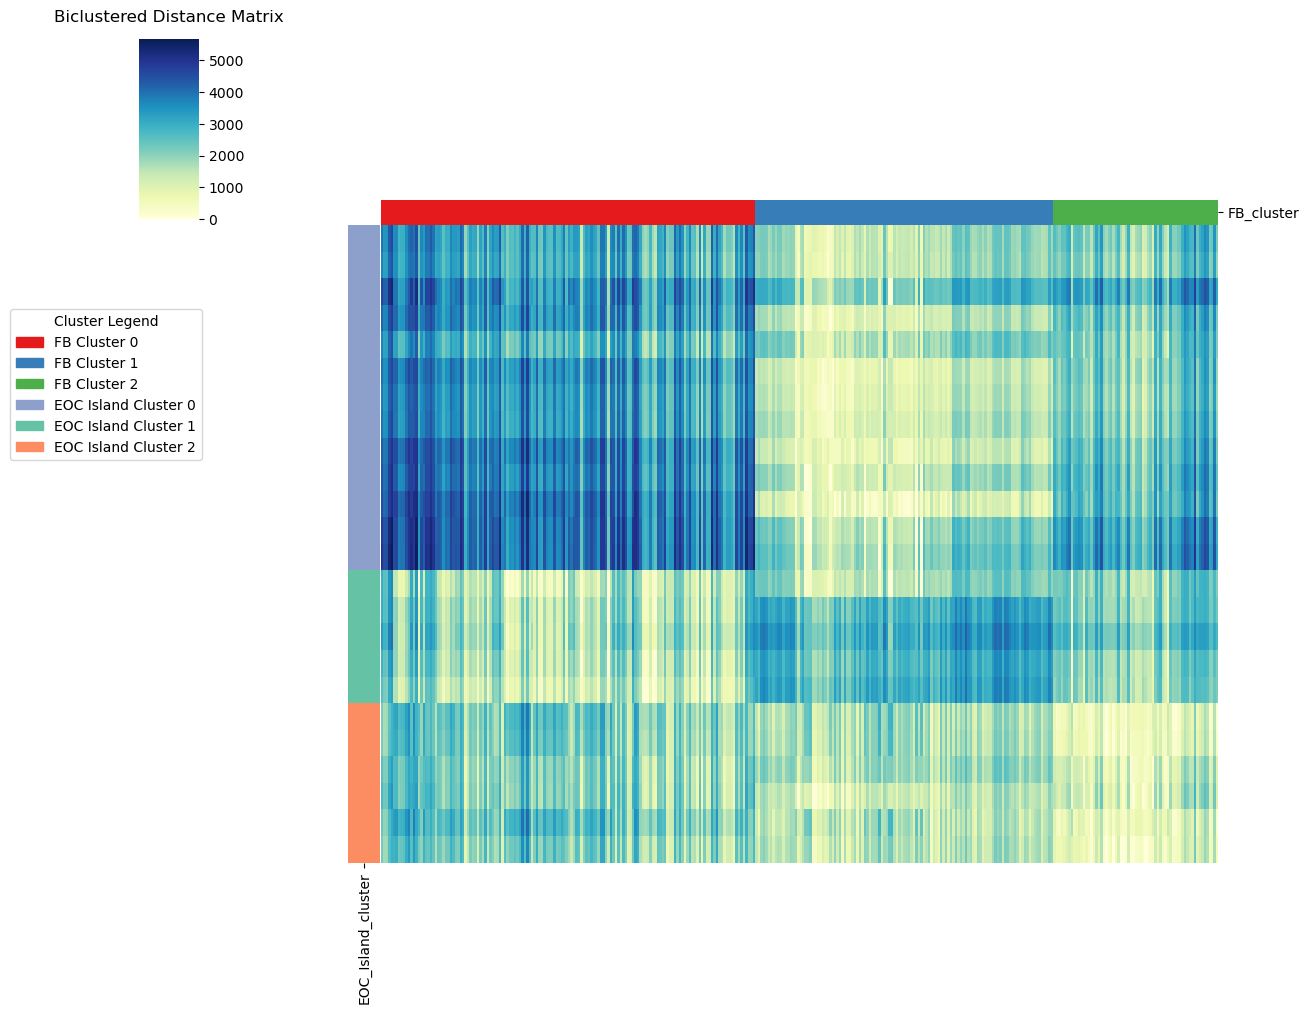

In [32]:
### subcluster FB based on distance to EOC islands using Biclustering methods
merged_polygon['Island'] = ['I'+str(i) for i in range(merged_polygon.shape[0])]
df = pd.DataFrame(columns=gdf_FB['cell'].tolist(), index=merged_polygon['Island'].tolist())
for i in range(gdf_FB.shape[0]):
    df[gdf_FB['cell'].tolist()[i]] = merged_polygon['geometry'].distance(gdf_FB.geometry[i]).tolist()

df['Island'] = df.index.tolist()
df = df.merge(merged_polygon, on='Island')

dist_df = df.drop(['area','geometry','Island'],axis=1)
dist_df.index = df.Island.tolist()

# Fit the model (you can try different number of clusters)
model = SpectralBiclustering(n_clusters=3, random_state=0)
model.fit(dist_df)

# Add the bicluster assignments
FB_clusters = pd.Series(model.column_labels_, index=dist_df.columns, name="FB_cluster")
EOC_clusters = pd.Series(model.row_labels_, index=dist_df.index, name="EOC_Island_cluster")

# Reorder rows and columns by cluster assignments
ordered_df = dist_df.iloc[model.row_labels_.argsort(),model.column_labels_.argsort()]


# Get unique cluster labels
fb_cluster_ids = FB_clusters.unique()
eoc_cluster_ids = EOC_clusters.unique()

# Generate distinct colors
fb_colors = sns.color_palette("Set1", len(fb_cluster_ids))
eoc_colors = sns.color_palette("Set2", len(eoc_cluster_ids))

# Map cluster IDs to colors
fb_color_map = dict(zip(fb_cluster_ids, fb_colors))
eoc_color_map = dict(zip(eoc_cluster_ids, eoc_colors))

# Create color Series aligned to matrix
col_colors = FB_clusters.map(fb_color_map)
row_colors = EOC_clusters.map(eoc_color_map)

sns.clustermap(
    ordered_df,
    row_cluster=False,  # already clustered
    col_cluster=False,  # already clustered
    row_colors=row_colors,
    col_colors=col_colors,
    cmap="YlGnBu",
    figsize=(12, 10),
    xticklabels=False,
    yticklabels=False
)

# Create legend handles
fb_patches = [Patch(color=color, label=f'FB Cluster {cl}') for cl, color in dict(sorted(fb_color_map.items(), key=lambda x: int(x[0]))).items()]
eoc_patches = [Patch(color=color, label=f'EOC Island Cluster {cl}') for cl, color in dict(sorted(eoc_color_map.items(), key=lambda x: int(x[0]))).items()]

# Add legends manually
legend_handles = fb_patches + eoc_patches
plt.legend(
    handles=legend_handles,
    title='Cluster Legend',
    bbox_to_anchor=(1.05, -0.5),
    loc='upper right',
    borderaxespad=0.
)

plt.title("Biclustered Distance Matrix", y=1.05)
plt.show()

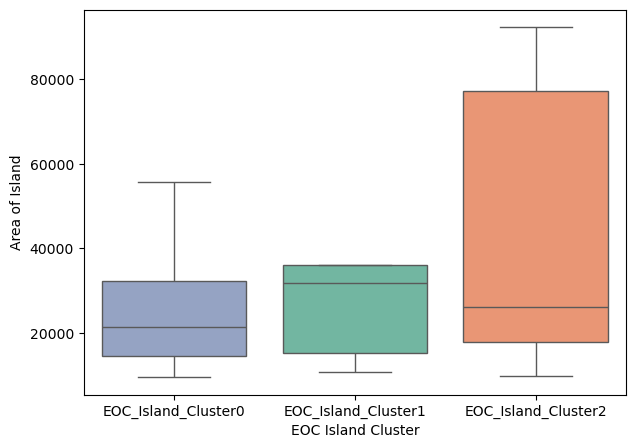

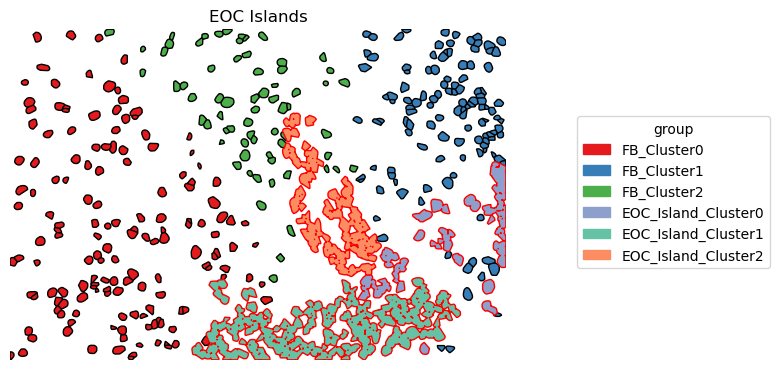

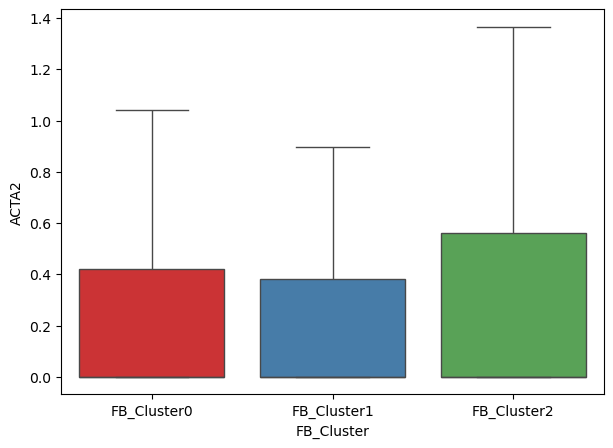

In [33]:
df_eoc = df[['area','geometry']]
df_eoc['EOC_Island_Cluster'] = ['EOC_Island_Cluster'+str(i) for i in model.row_labels_.tolist()]

df_fb = df.drop(['area','geometry','Island'],axis=1).T
df_fb['FB_Cluster'] = ['FB_Cluster'+str(i) for i in model.column_labels_.tolist()]

plt.figure(figsize=(7,5))
sns.boxplot(data=df_eoc, x='EOC_Island_Cluster', y='area', hue='EOC_Island_Cluster', showfliers=False, order=['EOC_Island_Cluster'+str(i) for i in range(3)], palette={'EOC_Island_Cluster'+str(i):j for i,j in eoc_color_map.items()})

plt.xlabel('EOC Island Cluster')
plt.ylabel('Area of Island')
plt.show()

fig, ax = plt.subplots()

color_map_1 = {'FB_Cluster'+str(i):j for i,j in fb_color_map.items()}
gdf_FB['FB_Cluster'] = ['FB_Cluster'+str(i) for i in model.column_labels_.tolist()]
gdf_FB['group_color'] = gdf_FB['FB_Cluster'].map(color_map_1)
gdf_FB.plot(ax=ax, color=gdf_FB['group_color'], edgecolor='black')

color_map_2 = {'EOC_Island_Cluster'+str(i):j for i,j in eoc_color_map.items()}
merged_polygon['EOC_Island_Cluster'] = ['EOC_Island_Cluster'+str(i) for i in model.row_labels_.tolist()]
merged_polygon['group_color'] = merged_polygon['EOC_Island_Cluster'].map(color_map_2)
merged_polygon.plot(ax=ax, color=merged_polygon['group_color'], edgecolor='red')


ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')

color_map = color_map_1 | color_map_2
color_map = {k:color_map[k] for k in ['FB_Cluster0','FB_Cluster1','FB_Cluster2','EOC_Island_Cluster0','EOC_Island_Cluster1','EOC_Island_Cluster2']}
handles = [Patch(color=col, label=cat) for cat, col in color_map.items()]
fig.legend(handles=handles, title='group', bbox_to_anchor=(1, 0.5), loc='center left')

plt.title("EOC Islands")
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(data=gdf_FB, x='FB_Cluster', y='ACTA2', hue='FB_Cluster', showfliers=False, order=['FB_Cluster'+str(i) for i in range(3)], palette={'FB_Cluster'+str(i):j for i,j in fb_color_map.items()})

plt.xlabel('FB_Cluster')
plt.ylabel('ACTA2')
plt.show()

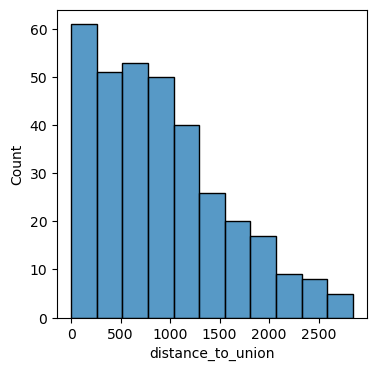

The # of FB cells touching the EOC cells is : 7


In [36]:
### subcluster FB based on distance to EOC islands using grouping methods
gdf_FB = gdf[gdf['big_cell_type'] == 'FB']
gdf_FB['distance_to_union'] = gdf_FB.geometry.apply(lambda g: g.distance(unary_union(merged_polygon['geometry'].tolist())))

plt.figure(figsize=(4,4))
sns.histplot(gdf_FB, x='distance_to_union')
plt.show()
print('The # of FB cells touching the EOC cells is : '+str(int((gdf_FB['distance_to_union'] == 0).sum())))



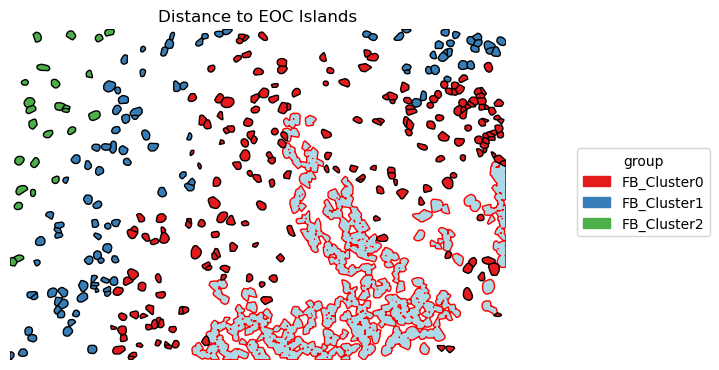

In [56]:
# Get unique cluster labels

def group_on_dist(d):
    if d < 1000:
        return 'Cluster0'
    elif d >=1000 and d < 2000:
        return 'Cluster1'
    else:
        return 'Cluster2'


gdf_FB['cluster'] = ['FB_'+group_on_dist(i) for i in gdf_FB['distance_to_union'].tolist()]

fb_cluster_ids = gdf_FB['cluster'].unique()
fb_cluster_ids = ['FB_Cluster0','FB_Cluster1','FB_Cluster2']
fb_colors = sns.color_palette("Set1", len(fb_cluster_ids))
fb_color_map = dict(zip(fb_cluster_ids, fb_colors))
color_map_1 = {str(i):j for i,j in fb_color_map.items()}
gdf_FB['group_color'] = gdf_FB['cluster'].map(color_map_1)

fig, ax = plt.subplots()

merged_polygon.plot(ax=ax, color='lightblue', edgecolor='red')
gdf_FB.plot(ax=ax, color=gdf_FB['group_color'], edgecolor='black')

color_map = {k:color_map[k] for k in ['FB_Cluster0','FB_Cluster1','FB_Cluster2']}
handles = [Patch(color=col, label=cat) for cat, col in color_map.items()]
fig.legend(handles=handles, title='group', bbox_to_anchor=(1, 0.5), loc='center left')

ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')

plt.title("Distance to"+" "+"EOC Islands")
plt.show()

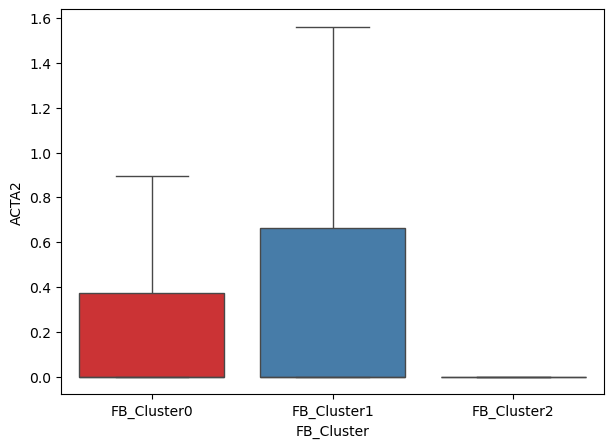

In [57]:
plt.figure(figsize=(7,5))
sns.boxplot(data=gdf_FB.merge(counts_sub,on='cell'), x='cluster', y='ACTA2', hue='cluster', showfliers=False, order=['FB_Cluster'+str(i) for i in range(3)], palette={str(i):j for i,j in fb_color_map.items()})

plt.xlabel('FB_Cluster')
plt.ylabel('ACTA2')
plt.show()

{'FB_ClusterFB_Cluster2': (0.8941176470588236,
  0.10196078431372549,
  0.10980392156862745),
 'FB_ClusterFB_Cluster0': (0.21568627450980393,
  0.49411764705882355,
  0.7215686274509804),
 'FB_ClusterFB_Cluster1': (0.30196078431372547,
  0.6862745098039216,
  0.2901960784313726)}